This notebook contains the code to analyze the data generated by the experiments. The code presented here forms the base of `create_plots.py`

In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from omegaconf import OmegaConf

from SOC_eigf.experiment_settings.settings import define_variables
from SOC_eigf.utils import stochastic_trajectories, control_objective
from SOC_eigf.method import SOC_Solver

### Exact solution

In [2]:
cfg = OmegaConf.load('experiment_cfg.yaml')
cfg.device = "cuda:0"
cfg.setting = "OU_quadratic_stable"
cfg.d = 20
cfg.T = 3.0
cfg.num_steps=1000
cfg.optim.batch_size=128*16
ts = torch.linspace(0, cfg.T, cfg.num_steps + 1).to(cfg.device)
x0, sigma, optimal_sde, neural_sde = define_variables(cfg, ts)
optimal_sde.use_learned_control = False

In [3]:
state0 = x0.repeat(cfg.optim.batch_size, 1)
states,_,_,_,_,target_controls = stochastic_trajectories(
                            optimal_sde,
                            state0,
                            ts.to(state0),
                            cfg.lmbd,
                            detach=True)

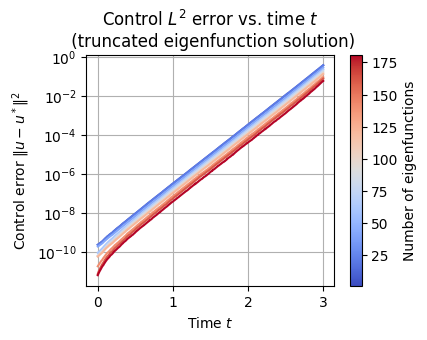

In [4]:
gs_controls = optimal_sde.exact_eigf_control(ts[:-1], states[:-1], 1)

fig, ax = plt.subplots(figsize=(4,3))
colormap_name = 'coolwarm'
colormap = plt.get_cmap(colormap_name)

max_k = 200
step = 20
ks = np.arange(1,max_k,step)
colors = [colormap(i / (len(ks) - 1)) for i in range(len(ks))]

# Normalize the color map to the range of ks
norm = mcolors.Normalize(vmin=ks.min(), vmax=ks.max())
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Needed for the colorbar

for k in ks:
    color = colormap(norm(k))
    eigf_controls = optimal_sde.exact_eigf_control(ts[:-1], states[:-1], k, verbose=False)
    err = ((eigf_controls - target_controls)**2).sum(dim=2).median(dim=1).values.cpu()
    ax.plot(ts[:-1].cpu(), err, color=color)
    ax.set_yscale('log')

# Add colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Number of eigenfunctions')
ax.set_ylabel(r'Control error $\|u-u^*\|^2$')
ax.set_xlabel('Time $t$')
ax.set_title('Control $L^2$ error vs. time $t$\n (truncated eigenfunction solution)')
ax.grid()
plt.show()

### Eigenfunction losses

In [5]:
experiment_name = "OU_stable_d20/EIGF"
run_names = ["ritz_GELU","var_GELU","pinn_GELU","rel_GELU"]

In [6]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 200
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            .transform(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean())
        )

print(df.columns)


Index(['itr', 'iteration_time', 'loss', 'main_loss', 'orth_loss', 'es_loss',
       'es_main_loss', 'es_orth_loss', 'eigf_error', 'grad_log_eigf_error',
       'control_objective_mean', 'control_objective_std', 'control_l2_error',
       'run_name', 'time', 'loss_EMA', 'main_loss_EMA', 'orth_loss_EMA',
       'es_loss_EMA', 'es_main_loss_EMA', 'es_orth_loss_EMA', 'eigf_error_EMA',
       'grad_log_eigf_error_EMA', 'control_l2_error_EMA'],
      dtype='object')


Visualize several metrics for the different loss functions side by side

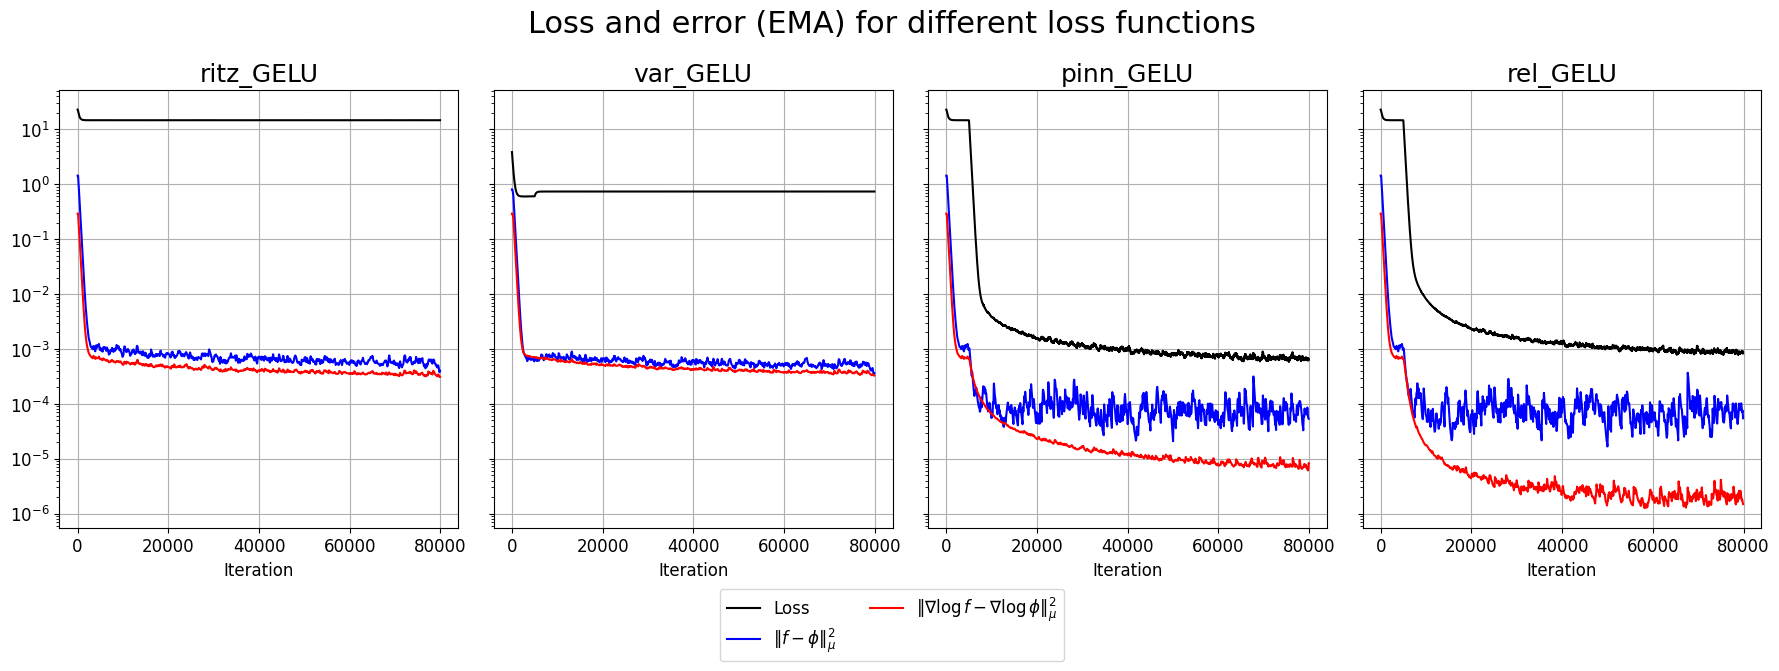

In [7]:
with plt.rc_context({'font.size': 12}):
    fig, axes = plt.subplots(1, len(run_names), figsize=(4.5*len(run_names),6),sharey=True,sharex=True)  # 1 row, 2 columns

    index = 'itr'
    col_appendix = "_EMA"
    labels = {
        'var_GELU': r'$\beta\langle f, \mathcal{L}f\rangle_\mu + \langle f, f\rangle_\mu$ (Var loss)',
        'ritz_GELU': r'$\frac{\langle f, \mathcal{L}f\rangle_\mu}{\langle f, f\rangle_\mu}$ (Deep Ritz loss)',
        'var_GAUSS': r'$\beta\langle f, \mathcal{L}f\rangle_\mu + \langle f, f\rangle_\mu$ (Var loss)',
        'ritz_GAUSS': r'$\frac{\langle f, \mathcal{L}f\rangle_\mu}{\langle f, f\rangle_\mu}$ (Deep Ritz loss)',
        'ritz': r'$\frac{\langle f, \mathcal{L}f\rangle_\mu}{\langle f, f\rangle_\mu}$ (Deep Ritz loss)',
        'pinn_GAUSS': r'$\|\mathcal{L}f-\lambda f\|_\mu^2$ (PINN loss)',
        'rel_GAUSS': r'$\|\mathcal{L}f/f-\lambda\|_\mu^2$ (Relative loss)',
        'log_rel_GAUSS': r'$\|\log(\mathcal{L}f/\lambda f)\|_\mu^2$ (Relative loss)'
    }

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"')
        run_df.plot(x=index,y='loss'+col_appendix, color='black', ax = axes[i],label='Loss')
        if 'eigf_error' in run_df.columns:
            run_df.plot(x=index,y='eigf_error'+col_appendix, color='blue', ax = axes[i],label=r"$\|f-\phi\|_{\mu}^2$")
            run_df.plot(x=index,y='grad_log_eigf_error'+col_appendix, color='red', ax = axes[i],label=r"$\|\nabla\log f-\nabla \log\phi\|_{\mu}^2$")

        axes[i].set_title(run_names[i],fontsize=18)
        axes[i].set_yscale('log')
        axes[i].grid()
        axes[i].set_xlabel('Time (s)' if index=="time" else "Iteration")
        
    for ax in axes:
        ax.legend().set_visible(False)

    # Create shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.12))
    plt.suptitle('Loss and error (EMA) for different loss functions',fontsize=22)

    plt.tight_layout()
    plt.show()

Compare a single metric

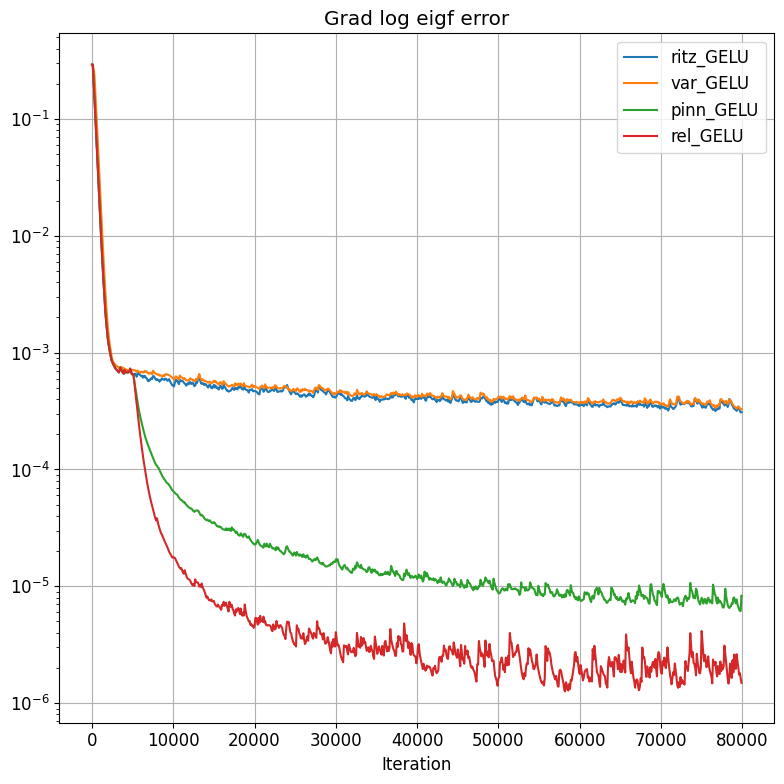

In [8]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(8,8))

    index = 'itr'
    col_appendix = "_EMA"
    ls = ['-','--','-.']

    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"').copy()
        run_df.plot(x=index,y='grad_log_eigf_error'+col_appendix, ax = ax, label=f'{run_names[i]}')
        
        ax.set_yscale('log')
        #ax.set_xlim(100,)
        ax.grid()
        ax.set_xlabel('Time (s)' if index=="time" else "Iteration")
    
    #ax.set_ylim(1e-4,10)
    plt.legend(loc='upper right')
    ax.set_title('Grad log eigf error')


    plt.tight_layout()
    plt.show()

### Control error: IDO vs COMBINED

In [9]:
experiment_name = "OU_stable_d20"
run_names = [
             'IDO/rel_entropy','IDO/log_variance','IDO/SOCM', 'IDO/adjoint_matching','FBSDE/FBSDE',
             'COMBINED/rel_entropy','COMBINED/log_variance','COMBINED/SOCM', 'COMBINED/adjoint_matching',
             ]

Error vs iteration

In [10]:
dfs = []
for run_name in run_names:
    df = pd.read_csv(f'experiments/{experiment_name}/{run_name}/logs.csv')
    df.dropna(how='all', inplace=True)
    df['run_name'] = run_name
    df['time'] = df['iteration_time'].cumsum()
    df.ffill(inplace=True)
    dfs.append(df)

df = pd.concat(dfs)

EMA_halflife = 200
for column in df.columns:
    if 'error' in column or 'loss' in column:
        df[f'{column}_EMA'] = (
            df.groupby('run_name')[column]
            .transform(lambda x: np.exp(x.apply(lambda x: np.log(x)).ewm(halflife=EMA_halflife, adjust=False).mean()))
            #.transform(lambda x: x.apply(lambda x: x.ewm(halflife=EMA_halflife, adjust=False).mean()))
        )

print(df.columns)

Index(['itr', 'iteration_time', 'loss', 'control_objective_mean',
       'control_objective_std', 'control_l2_error', 'run_name', 'time',
       'loss_EMA', 'control_l2_error_EMA'],
      dtype='object')


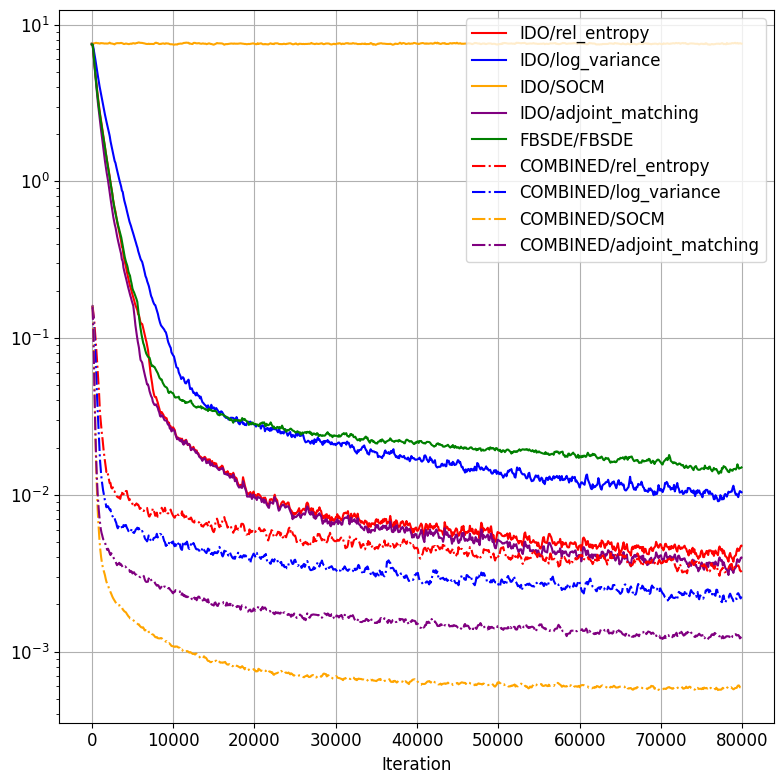

In [11]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(figsize=(8,8))

    index = 'itr'
    col_appendix = "_EMA"
    
    colors = []
    ls = []
    for run_name in run_names:
        if 'IDO' in run_name or 'EIGF' in run_name or 'FBSDE' in run_name:
            ls += ['-']
        else:
            ls += ['-.']
        
        if 'variance' in run_name:
            colors += ['blue']
        elif 'rel_entropy' in run_name:
            colors += ['red']
        elif 'FBSDE' in run_name:
            colors += ['green']
        elif 'SOCM' in run_name:
            colors += ['orange']
        elif 'adjoint_matching' in run_name:
            colors += ['purple']
        elif 'EIGF' in run_name:
            colors += ['black']


    for i in range(len(run_names)):
        run_df = df.query(f'run_name=="{run_names[i]}"')
        run_df.plot(x=index,y='control_l2_error'+col_appendix, ax = ax, label=f'{run_names[i]}', ls=ls[i],color=colors[i])

    ax.set_yscale('log')
    ax.grid()
    ax.set_xlabel('Time (s)' if index=="time" else "Iteration")
    
    #ax.set_xlim(0,30000)
    #ax.set_ylim(1e-4,10)
    plt.legend()

    plt.tight_layout()
    plt.show()

Error vs. simulation time

In [12]:
run_names = [
             'IDO/rel_entropy','IDO/log_variance','IDO/SOCM', 'IDO/adjoint_matching','FBSDE/FBSDE',
             'COMBINED/rel_entropy','COMBINED/log_variance','COMBINED/SOCM', 'COMBINED/adjoint_matching',
             ]

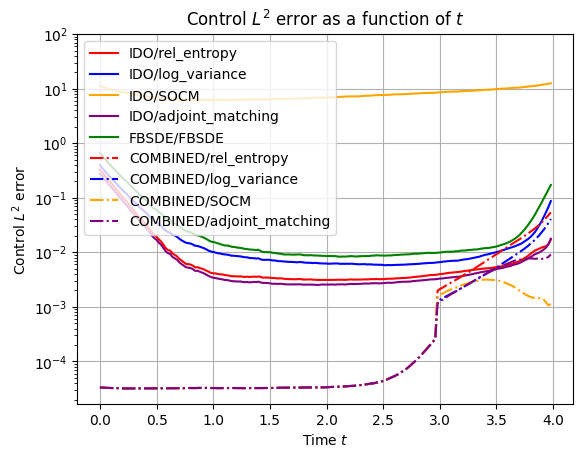

In [13]:
itrs = [75000]*(len(run_names))
labels = run_names
for i in range(len(run_names)):
    cfg = OmegaConf.load(f'experiments/{experiment_name}/{run_names[i]}/cfg.yaml')
    cfg.num_steps=200
    cfg.device = 'cuda:5'

    cfg.gpu = 5
    ts = torch.linspace(0, cfg.T, cfg.num_steps + 1).to(cfg.device)
    
    x0, sigma, optimal_sde, neural_sde = define_variables(cfg, ts)
    optimal_sde.use_learned_control = False

    state0 = x0.repeat(cfg.optim.batch_size*16, 1)
    
    colors = []
    ls = []
    for run_name in run_names:
        if 'IDO' in run_name or 'rel_GELU' in run_name or 'FBSDE' in run_name:
            ls += ['-']
        else:
            ls += ['-.']
        
        if 'variance' in run_name:
            colors += ['blue']
        elif 'rel_entropy' in run_name:
            colors += ['red']
        elif 'FBSDE' in run_name:
            colors += ['green']
        elif 'adjoint_matching' in run_name:
            colors += ['purple']
        elif 'SOCM' in run_name:
            colors += ['orange']
        elif 'rel_GELU' in run_name:
            colors += ['black']


    if i == 0:
        states,_,_,_,_,target_control = stochastic_trajectories(
                                    optimal_sde,
                                    state0,
                                    ts.to(state0),
                                    cfg.lmbd,
                                    detach=True)
        target_control = target_control.cpu()
    if cfg.method == "EIGF":
        try:
            checkpoint = torch.load(f'experiments/{experiment_name}/{run_names[i]}/neural_sde_weights.pth',map_location='cuda:5')
        except FileNotFoundError as e:
            print('Error: Please train EIGF model before attempting to train combined model!')
            raise e
        
        neural_sde.load_state_dict(checkpoint, strict=False)
    solver = SOC_Solver(
            neural_sde,
            x0,
            None,
            T=cfg.T,
            num_steps=cfg.num_steps,
            lmbd=cfg.lmbd,
            d=cfg.d,
            sigma=sigma,
            solver_cfg=cfg.solver
        )
    if cfg.method != "EIGF":
        solver.load_state_dict(torch.load(f'experiments/{experiment_name}/{run_names[i]}/solver_weights_{itrs[i]:_}.pth',map_location='cuda:5',weights_only=True),strict=True)
    learned_control = solver.neural_sde.control(ts[:-1],states[:-1]).cpu()
    norm_sqd_diff = torch.sum((target_control - learned_control) ** 2,dim=-1).mean(dim=1)
    plt.plot(ts[:-1].cpu(),norm_sqd_diff.detach().cpu(),label=labels[i],color=colors[i],ls=ls[i])

plt.yscale('log')
plt.ylim(None,1e2)
plt.grid()
plt.legend(loc='upper left')
plt.xlabel('Time $t$')
plt.ylabel('Control $L^2$ error')
plt.title('Control $L^2$ error as a function of $t$')
plt.show()